In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

SEEDS = 42

np.random.seed(SEEDS)
tf.random.set_seed(SEEDS)

In [32]:
'''In this step we download and load the data set and split it into two parts ( Train and test sets ) 
'''
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True,
)

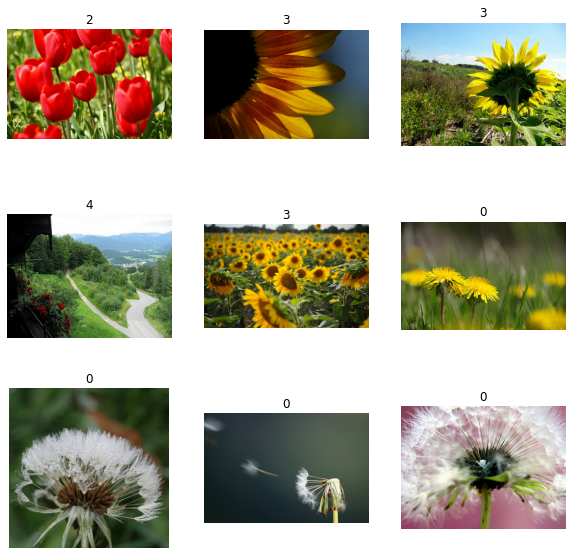

In [33]:
''' using the famous visualisation library matplotlib, we are here Visualizing some exemples in our dataset'''
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [34]:
'''Now we set hyperparameters like the the number of classes and the way we will optimize the pipline.
we also apply data augmentation.
Hyperparemeters like SCHEDULE_LENGTH and SCHEDULE_BOUNDARIES are determined based on empirical results.
'''
RESIZE_TO = 384
CROP_TO = 224
BATCH_SIZE = 64
STEPS_PER_EPOCH = 10
AUTO = tf.data.AUTOTUNE  # optimise the pipeline performance
NUM_CLASSES = 5  # number of classes
SCHEDULE_LENGTH = (
    500  # we will train on lower resolution images and will still attain good results
)
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]  # more the dataset size the schedule length increase

In [35]:
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

'''
because our data is not big, and for training our model we need huge number of images to give us good results, there is a technique
called data augmentation so we will try to apply that to our dataset.
What data augmentation do is random horizontal flipping or small random rotations.
'''
@tf.function
def preprocess_train(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    image = image / 255.0
    return (image, label)


@tf.function
def preprocess_test(image, label):
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = image / 255.0
    return (image, label)


DATASET_NUM_TRAIN_EXAMPLES = train_ds.cardinality().numpy()

repeat_count = int(
    SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH
)
repeat_count += 50 + 1  # To ensure at least there are 50 epochs of training

In [36]:
'''we will fit our model before the test'''
pipeline_train = (
    train_ds.shuffle(10000)
    .repeat(repeat_count)  # Repeat dataset_size / num_steps
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    validation_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

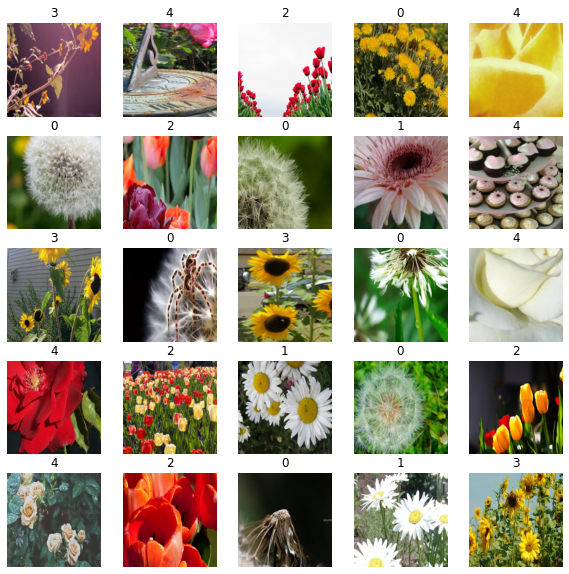

In [37]:
image_batch, label_batch = next(iter(pipeline_train))
'''
by applying data preprocessing to the first exemples in our dataset, we will visualize what the augmented samples look like.
'''
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis("off")

In [38]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)

# BigTransfer (BiT) model

In [39]:
'''
Now we wil  build a bigtransfer model class
'''
class MyBiTModel(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.bit_model = module

    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)


model = MyBiTModel(num_classes=NUM_CLASSES, module=bit_module)

In [40]:
'''before fitting our model, we choosed categorical_crossentropy as loss function and Gradient descend as optimizer'''
learning_rate = 0.003 * BATCH_SIZE / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [41]:
'''Before fitting the model we need to compile it and specifie the optimizer and the evaluating mytric we will use. In our case
we will use accuracy'''
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [42]:
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=2, restore_best_weights=True
    )
]

In [ ]:
'''we will fit our model befor the test'''
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    epochs=3,
    steps_per_epjoch=STEPS_PER_EPOCH,
    validation_data=pipeline_validation,
    callbacks=train_callbacks,
)

In [ ]:
'''now we will plot the training and validation metrics'''
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(history)

In [ ]:
'''Finally we will evaluate de performance of our model by calculating accuracy'''
accuracy = model.evaluate(pipeline_validation)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

In [ ]:
'''In this example we build an image classification model using BigTransfer which is transfer learning method for classifing 
images. The hyperparameters are simplified compared to the classic image classification model ( logistic regression for exemple
). We can train large supervised datasets ( labelled data sets) and fine-tuning the model on a target task but the main thing 
is the normalization layers ( data preprocessing ) and scaling the architecture capacity. This two who differs from a model to 
an other.'''